Generate labels for each landmark in gaussian images:

In [54]:
import os
import monai
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet
from monai.data import DataLoader, CacheDataset, ImageDataset, Dataset, image_reader
from monai.data.utils import pad_list_data_collate
from monai.transforms import Compose, ScaleIntensity, ToTensor,LoadImaged, ScaleIntensityd, ToTensord,EnsureChannelFirstd
import SimpleITK as sitk
from monai.data.image_reader import ITKReader
from monai.losses import DiceLoss
from monai.metrics import MSEMetric
import dataset
from dataset import PelvisDataset
import numpy as np
import sklearn
from monai.metrics import compute_hausdorff_distance
from UNETR import UNETR
from scipy.ndimage import label
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy import ndimage

import ipywidgets as widgets


Connected components

In [55]:
# Función para mostrar imágenes de inputs, targets y outputs
def plot_results(inputs, targets, outputs):
    depth_slice = inputs[:, :, :, :, :]
    depth_slice_target = targets[:, :, :, :, :]
    depth_slice_outputs = outputs[:, :, :, :, :]

    def plot_image(i):
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        image_array = depth_slice[0, :, i, :, :].cpu().detach().numpy()
        image_array_target = depth_slice_target[0, :, i, :, :].cpu().detach().numpy()
        image_array_outputs = depth_slice_outputs[0, :, i, :, :].cpu().detach().numpy()

        axes[0].imshow(image_array[0, :, :], cmap="gray")
        axes[0].set_title("inputs")
        axes[0].axis('off')

        axes[1].imshow(image_array_target[0, :, :], cmap="gray")
        axes[1].set_title("target")
        axes[1].axis('off')

        axes[2].imshow(image_array_outputs[0, :, :], cmap="gray")
        axes[2].set_title("output")
        axes[2].axis('off')

        plt.show()

    widgets.interact(plot_image, i=widgets.IntSlider(min=0, max=depth_slice.shape[2]-1, step=1, value=22))


In [56]:
def plot_results(input):
        depth_slice = input
        
        def plot_image(i):
                # fig, axes = plt.subplots(1, 1, figsize=(10, 5))


                # image_array_target = depth_slice_target[0, :, i, :, :].cpu().detach().numpy()
                # image_array_outputs = depth_slice_outputs[0, :, i, :, :].cpu().detach().numpy()

                plt.imshow(input[i, :, :], cmap="gray")
                # plt.title("inputs")
                # plt.axis('off')


                plt.show()
                
        widgets.interact(plot_image, i=widgets.IntSlider(min=0, max=depth_slice.shape[2]-1, step=1, value=22))

TRAIN FILES

In [58]:
path_gaussian_images =  "/home/paulagmtz/TFM_PAULA_24/DATA_TFM/train_files/landmarks/"
list_gaussians = os.listdir(path_gaussian_images)
for imagen in list_gaussians:
    print(imagen)
    im = sitk.ReadImage(path_gaussian_images + imagen, sitk.sitkFloat32)
    im_arr = sitk.GetArrayFromImage(im)
    

    class_segmentation = im_arr.astype(np.uint8)

    # Perform connected components labeling on the thresholded segmentation
    labeled, num_features = label(im_arr)
    print(num_features)
    
    # Filter out small components (adjust the minimum size as needed)

    # max_size = 0
    component_mask_complete = np.zeros(im_arr.shape)
    for label_value in range(1, num_features + 1):
        component_mask = (labeled == label_value).astype(np.float32)
        component_size = component_mask.sum()
        component_mask_complete = component_mask_complete + component_mask
        # Asigna un label distinto a cada componente
        for i in range(component_mask.shape[0]):
            for j in range(component_mask.shape[1]):
                for k in range(component_mask.shape[2]):
                    if (component_mask[i][j][k]) == 1:
                        component_mask_complete[i][j][k] = label_value

    # plt.imshow(component_mask_complete[30,:,:])
    # plt.show()
    
    
    labeled_gaussian = sitk.GetImageFromArray(component_mask_complete)
    sitk.WriteImage(labeled_gaussian, "/home/paulagmtz/TFM_PAULA_24/DATA_TFM/train_files/multilabel_landmarks/" + imagen)
    # print(component_mask_complete.shape)
    plot_results(component_mask_complete)
    


P_1765645_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1572096_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10535603_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_808211848_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10279644_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2066635_ANTRO.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2197057_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1195472_ANTROP.nrrd
6


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1165093_ANTROP.nrrd
0


interactive(children=(IntSlider(value=22, description='i', max=64), Output()), _dom_classes=('widget-interact'…

P_10182352_GIN.nrrd
6


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_802351174_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1480679_ANTROP.nrrd
6


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2387418_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10208792_ANDRO.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2111864_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1571575_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1715822_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_840121405_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1683063_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2370576_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_840248498_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10390193_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1905095_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1132495_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2369281_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1993084_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1612231_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10550586_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1427769_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10292632_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10860322_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1874278_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10255365_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10273428_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1663679_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1796248_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_808475095_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2133072_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_80411795_ANDRO.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_840057000_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2207042_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2170236-GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

VAL FILES

P_2043819_ANDRO.nrrd
7


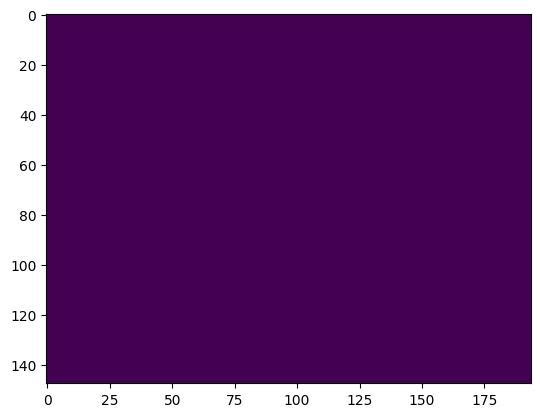

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2241943_ANTROP.nrrd
7


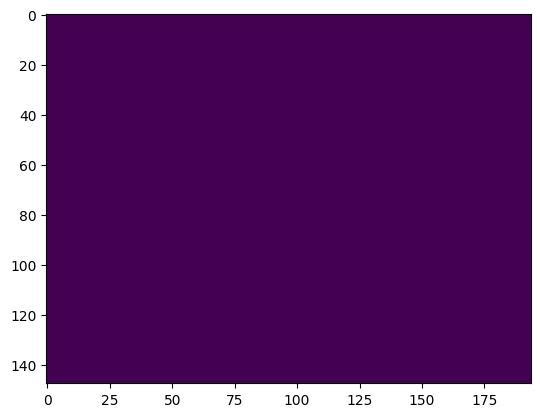

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2418993_GIN.nrrd
7


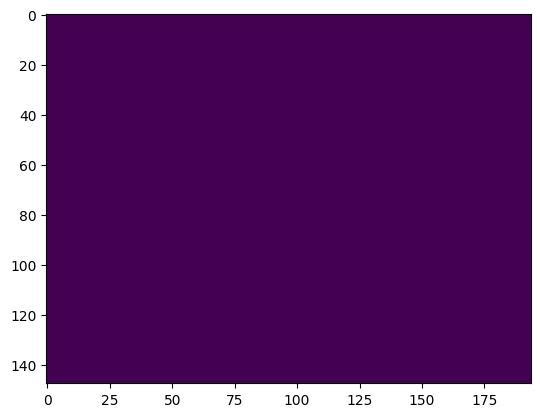

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_840114360_ANTROP.nrrd
7


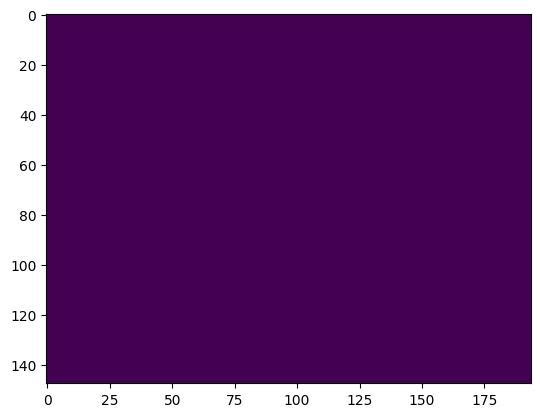

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10253637_ANTROP.nrrd
7


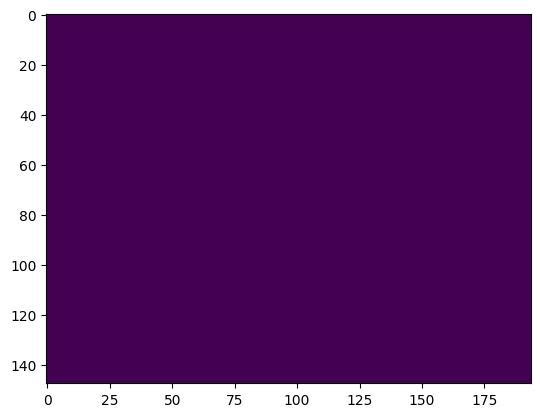

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10265450_ANTROP.nrrd
7


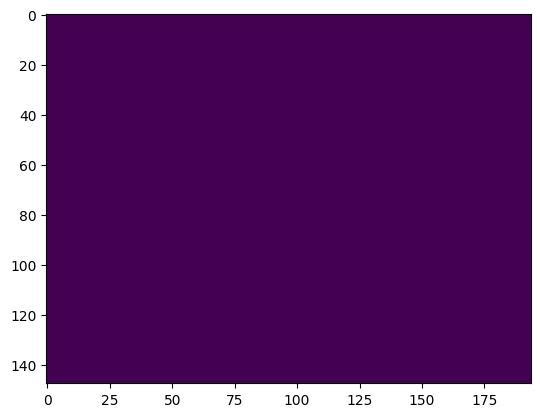

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2319187_GIN.nrrd
7


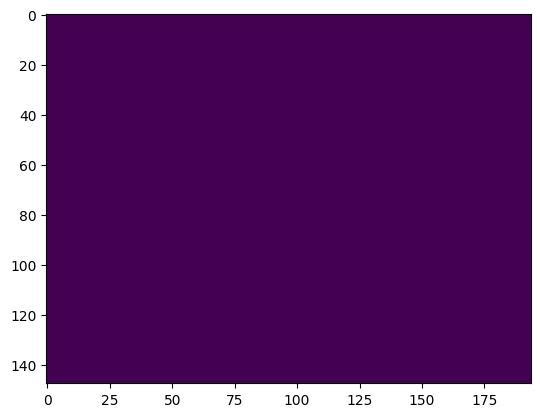

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2146763_GIN.nrrd
7


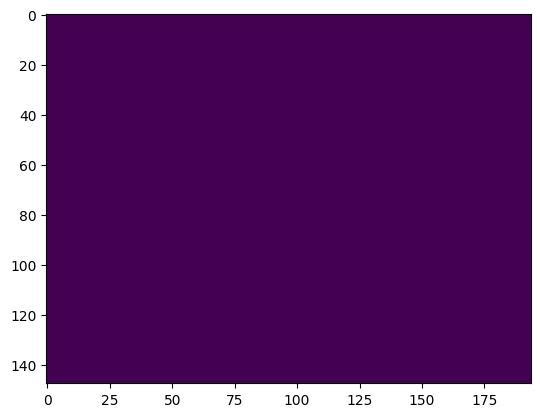

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2196069_ANTROP.nrrd
7


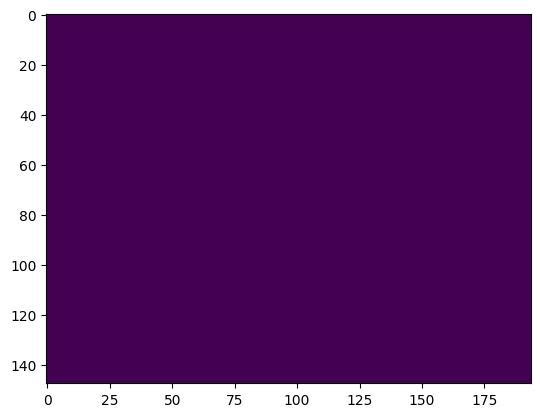

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_840109842_GIN.nrrd
7


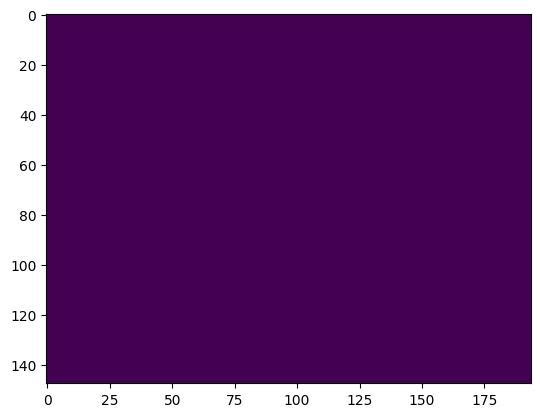

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2089803_GIN.nrrd
7


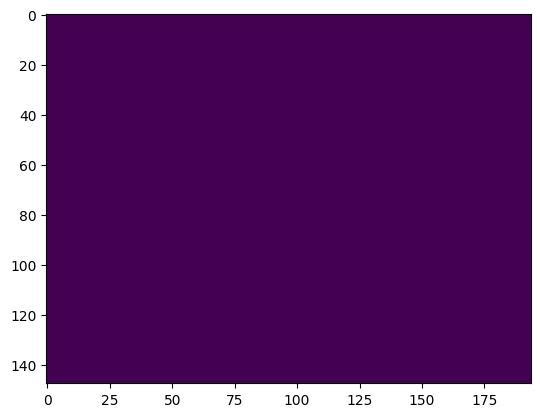

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10643160_ANTROP.nrrd
7


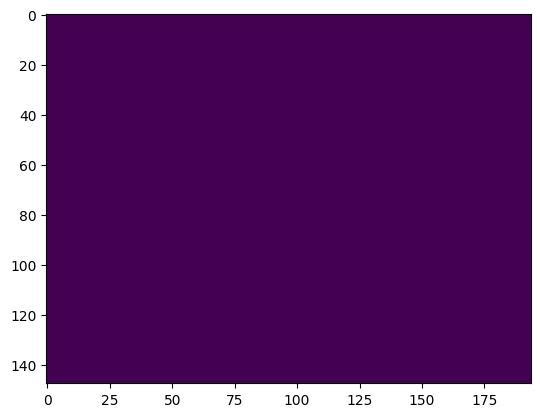

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1059692_ANTROP.nrrd
7


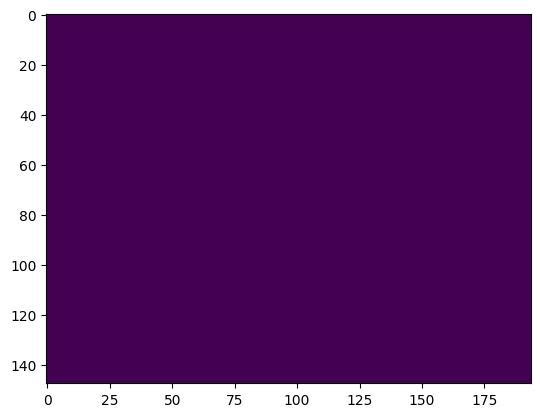

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_808761105_PLATI.nrrd
7


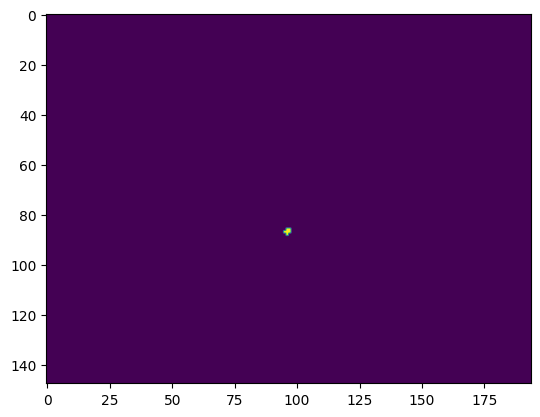

interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

In [59]:
path_gaussian_images =  "/home/paulagmtz/TFM_PAULA_24/DATA_TFM/val_files/landmarks/"
list_gaussians = os.listdir(path_gaussian_images)
for imagen in list_gaussians:
    print(imagen)
    im = sitk.ReadImage(path_gaussian_images + imagen, sitk.sitkFloat32)
    im_arr = sitk.GetArrayFromImage(im)
    

    class_segmentation = im_arr.astype(np.uint8)

    # Perform connected components labeling on the thresholded segmentation
    labeled, num_features = label(im_arr)
    print(num_features)
    
    # Filter out small components (adjust the minimum size as needed)

    # max_size = 0
    component_mask_complete = np.zeros(im_arr.shape)
    for label_value in range(1, num_features + 1):
        component_mask = (labeled == label_value).astype(np.float32)
        component_size = component_mask.sum()
        component_mask_complete = component_mask_complete + component_mask
        # Asigna un label distinto a cada componente
        for i in range(component_mask.shape[0]):
            for j in range(component_mask.shape[1]):
                for k in range(component_mask.shape[2]):
                    if (component_mask[i][j][k]) == 1:
                        component_mask_complete[i][j][k] = label_value


    labeled_gaussian = sitk.GetImageFromArray(component_mask_complete)
    sitk.WriteImage(labeled_gaussian, "/home/paulagmtz/TFM_PAULA_24/DATA_TFM/val_files/multilabel_landmarks/" + imagen)
    # print(component_mask_complete.shape)
    plot_results(component_mask_complete)
    


TEST FILES

In [60]:
path_gaussian_images =  "/home/paulagmtz/TFM_PAULA_24/DATA_TFM/test_files/landmarks/"
list_gaussians = os.listdir(path_gaussian_images)
for imagen in list_gaussians:
    print(imagen)
    im = sitk.ReadImage(path_gaussian_images + imagen, sitk.sitkFloat32)
    im_arr = sitk.GetArrayFromImage(im)
    

    class_segmentation = im_arr.astype(np.uint8)

    # Perform connected components labeling on the thresholded segmentation
    labeled, num_features = label(im_arr)
    print(num_features)
    
    # Filter out small components (adjust the minimum size as needed)

    # max_size = 0
    component_mask_complete = np.zeros(im_arr.shape)
    for label_value in range(1, num_features + 1):
        component_mask = (labeled == label_value).astype(np.float32)
        component_size = component_mask.sum()
        component_mask_complete = component_mask_complete + component_mask
        # Asigna un label distinto a cada componente
        for i in range(component_mask.shape[0]):
            for j in range(component_mask.shape[1]):
                for k in range(component_mask.shape[2]):
                    if (component_mask[i][j][k]) == 1:
                        component_mask_complete[i][j][k] = label_value


    labeled_gaussian = sitk.GetImageFromArray(component_mask_complete)
    sitk.WriteImage(labeled_gaussian, "/home/paulagmtz/TFM_PAULA_24/DATA_TFM/test_files/multilabel_landmarks/" + imagen)
    # print(component_mask_complete.shape)
    plot_results(component_mask_complete)
    


P_10061362_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_840104562_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2379678_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10190176_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10055401_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1683587_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2002362_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1444487_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1716840_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_1825137_PLATI.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2039080_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2156592_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_808704728_ANTROP.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2046474_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=377), Output()), _dom_classes=('widget-interact…

P_10240629_GIN.nrrd
6


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_840131653_ANDRO.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_2114245_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10040985_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…

P_10034664_GIN.nrrd
7


interactive(children=(IntSlider(value=22, description='i', max=193), Output()), _dom_classes=('widget-interact…